In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [2]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow.keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline

In [4]:
import os
import sys
os.chdir(sys.path[0])

In [5]:
df=pd.read_csv("gt_training.csv")  
df.head()

,Image ID,Image class
0,1,Homogeneous
1,2,Homogeneous
2,3,Homogeneous
3,4,Homogeneous
4,5,Homogeneous


In [6]:
def process_files(x):
    if (len(str(x)) == 1):
        return "0000"+str(x)+".png"
    if (len(str(x)) == 2):
        return "000"+str(x)+".png"
    if (len(str(x)) == 3):
        return "00"+str(x)+".png"
    if (len(str(x)) == 4):
        return "0"+str(x)+".png"
    if (len(str(x)) == 5):
        return str(x)+".png"

In [7]:
df['Image ID'] = df['Image ID'].map(lambda x: process_files(x))
df.head()

,Image ID,Image class
0,00001.png,Homogeneous
1,00002.png,Homogeneous
2,00003.png,Homogeneous
3,00004.png,Homogeneous
4,00005.png,Homogeneous


In [8]:
from PIL import Image
im = Image.open("training/00001.png")
im.size

(78, 78)

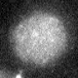

In [9]:
from IPython.display import Image 
Image(filename='training/00001.png')

In [10]:
datagen=ImageDataGenerator(rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator=datagen.flow_from_dataframe(dataframe=df, directory="training", 
                                            x_col="Image ID", y_col="Image class", class_mode="categorical", 
                                            target_size=(78,78), batch_size=113, color_mode='grayscale')

Found 8701 images belonging to 6 classes.


In [11]:
train_generator.image_shape

(78, 78, 1)

In [12]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=df,directory="test",
                                                x_col="Image ID", y_col="Image class", class_mode="categorical",
                                                target_size=(78,78), batch_size=113, color_mode='grayscale',shuffle=False)

Found 2720 images belonging to 6 classes.


In [13]:
test_generator.image_shape

(78, 78, 1)

In [14]:
validation_datagen=ImageDataGenerator(rescale=1./255.)

validation_generator=validation_datagen.flow_from_dataframe(dataframe=df,directory="validation",
                                                x_col="Image ID", y_col="Image class", class_mode="categorical",
                                                target_size=(78,78), batch_size=113, color_mode='grayscale',shuffle=False)

Found 2175 images belonging to 6 classes.


In [15]:
validation_generator.image_shape

(78, 78, 1)

In [16]:
x_train = train_generator.filenames
y_train = train_generator.labels

In [17]:
x_val = validation_generator.filenames
y_val = validation_generator.labels

In [18]:
x_test = test_generator.filenames
y_test = test_generator.labels
label_index = test_generator.class_indices

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(6, 7, input_shape=(78, 78, 1)))#, activation='relu'))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, 4))#, activation='relu'))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(32, 3))#, activation='relu'))
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(150))#, activation='relu'))
model.add(layers.LeakyReLU())
model.add(layers.Dense(6, activation='softmax'))


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 72, 6)         300       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 72, 72, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        1552      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          4

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01, decay=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
cell_model = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=1000)

Epoch 1/1000
77/77 [==============================] - 13s 172ms/step - loss: 1.2697 - accuracy: 0.4656 - val_loss: 0.7162 - val_accuracy: 0.7416
Epoch 2/1000
61/77 [======================>.......] - ETA: 1s - loss: 0.9365 - accuracy: 0.6377

KeyboardInterrupt: 

In [23]:
pred=model.predict_generator(test_generator, verbose=1)  # for confusion matrix

25/25 [==============================] - 2s 87ms/step


In [24]:
test_model = model.evaluate_generator(generator=test_generator)
test_model

[0.19721359468996524, 0.94375]

In [25]:
y_pred = np.argmax(pred, axis=1)
y_pred.shape

(2720,)

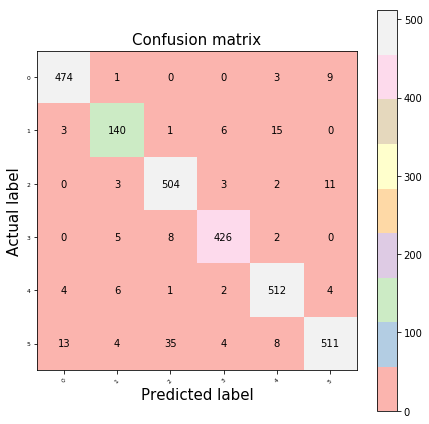

In [26]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5"], rotation=45, size = 6)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5"], size = 6)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       487
           1       0.88      0.85      0.86       165
           2       0.92      0.96      0.94       523
           3       0.97      0.97      0.97       441
           4       0.94      0.97      0.96       529
           5       0.96      0.89      0.92       575

   micro avg       0.94      0.94      0.94      2720
   macro avg       0.94      0.93      0.94      2720
weighted avg       0.94      0.94      0.94      2720



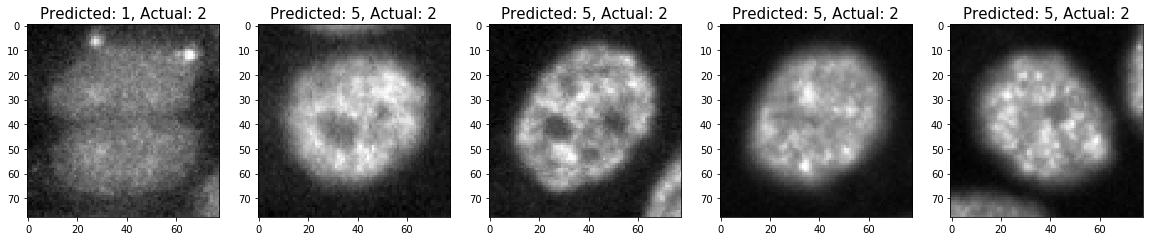

In [28]:

#Misclassified images
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_pred):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1


plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    data = image.imread('./test/'+x_test[badIndex])
    plt.imshow(data, cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(y_pred[badIndex], y_test[badIndex]), fontsize = 15)

In [29]:
label_index

{'Centromere': 0,
 'Golgi': 1,
 'Homogeneous': 2,
 'NuMem': 3,
 'Nucleolar': 4,
 'Speckled': 5}

In [30]:
model1 = models.Sequential()
model1.add(layers.Conv2D(6, 7, input_shape=(78, 78, 1)))#, activation='relu'))
model1.add(layers.LeakyReLU())
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(16, 4))#, activation='relu'))
model1.add(layers.LeakyReLU())
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Conv2D(32, 3))#, activation='relu'))
model1.add(layers.LeakyReLU())
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Flatten())
model1.add(layers.Dense(150))#, activation='relu'))
model1.add(layers.LeakyReLU())
model1.add(layers.Dense(6, activation='softmax'))


In [31]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 72, 72, 6)         300       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 72, 72, 6)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 16)        1552      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)         

In [32]:
model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01, decay=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
datagen=ImageDataGenerator(rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator=datagen.flow_from_dataframe(dataframe=df, directory="./training", 
                                            x_col="Image ID", y_col="Image class", class_mode="categorical", 
                                            target_size=(78,78), batch_size=113, color_mode='grayscale')

Found 8701 images belonging to 6 classes.


In [34]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=df,directory="./test",
                                                x_col="Image ID", y_col="Image class", class_mode="categorical",
                                                target_size=(78,78), batch_size=113, color_mode='grayscale',shuffle=False)

Found 2720 images belonging to 6 classes.


In [35]:
cell_model1 = model1.fit_generator(generator=train_generator,validation_data=test_generator, epochs=1000)

Epoch 1/1000
77/77 [==============================] - 11s 141ms/step - loss: 1.2709 - accuracy: 0.4656 - val_loss: 0.9393 - val_accuracy: 0.6449
Epoch 2/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.9660 - accuracy: 0.6145 - val_loss: 0.7818 - val_accuracy: 0.6706
Epoch 3/1000
77/77 [==============================] - 9s 117ms/step - loss: 0.7952 - accuracy: 0.6835 - val_loss: 0.6788 - val_accuracy: 0.7423
Epoch 4/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.6930 - accuracy: 0.7260 - val_loss: 0.6404 - val_accuracy: 0.7625
Epoch 5/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.6258 - accuracy: 0.7597 - val_loss: 0.5072 - val_accuracy: 0.8169
Epoch 6/1000
77/77 [==============================] - 9s 120ms/step - loss: 0.5796 - accuracy: 0.7736 - val_loss: 0.4679 - val_accuracy: 0.8467
Epoch 7/1000
77/77 [==============================] - 9s 119ms/step - loss: 0.5625 - accuracy: 0.7882 - val_loss: 0.5367 - val_accuracy

77/77 [==============================] - 9s 116ms/step - loss: 0.2091 - accuracy: 0.9251 - val_loss: 0.2818 - val_accuracy: 0.9136
Epoch 114/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.2057 - accuracy: 0.9275 - val_loss: 0.2278 - val_accuracy: 0.9305
Epoch 115/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.2006 - accuracy: 0.9267 - val_loss: 0.2288 - val_accuracy: 0.9301
Epoch 116/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.2054 - accuracy: 0.9279 - val_loss: 0.2119 - val_accuracy: 0.9368
Epoch 117/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.2156 - accuracy: 0.9205 - val_loss: 0.2213 - val_accuracy: 0.9309
Epoch 118/1000
77/77 [==============================] - 9s 117ms/step - loss: 0.1964 - accuracy: 0.9293 - val_loss: 0.2324 - val_accuracy: 0.9239
Epoch 119/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.2166 - accuracy: 0.9225 - val_loss: 0.2193 - val_accuracy: 

77/77 [==============================] - 9s 117ms/step - loss: 0.1550 - accuracy: 0.9439 - val_loss: 0.1912 - val_accuracy: 0.9390
Epoch 226/1000
77/77 [==============================] - 9s 117ms/step - loss: 0.1507 - accuracy: 0.9443 - val_loss: 0.1892 - val_accuracy: 0.9390
Epoch 227/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.1533 - accuracy: 0.9428 - val_loss: 0.1941 - val_accuracy: 0.9397
Epoch 228/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.1520 - accuracy: 0.9456 - val_loss: 0.1874 - val_accuracy: 0.9404
Epoch 229/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.1418 - accuracy: 0.9505 - val_loss: 0.1957 - val_accuracy: 0.9386
Epoch 230/1000
77/77 [==============================] - 9s 117ms/step - loss: 0.1499 - accuracy: 0.9443 - val_loss: 0.1788 - val_accuracy: 0.9426
Epoch 231/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.1509 - accuracy: 0.9462 - val_loss: 0.1783 - val_accuracy: 

77/77 [==============================] - 9s 116ms/step - loss: 0.1225 - accuracy: 0.9555 - val_loss: 0.1858 - val_accuracy: 0.9415
Epoch 338/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.1134 - accuracy: 0.9586 - val_loss: 0.1515 - val_accuracy: 0.9500
Epoch 339/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.1312 - accuracy: 0.9518 - val_loss: 0.1673 - val_accuracy: 0.9460
Epoch 340/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.1245 - accuracy: 0.9548 - val_loss: 0.1631 - val_accuracy: 0.9474
Epoch 341/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.1232 - accuracy: 0.9556 - val_loss: 0.1603 - val_accuracy: 0.9474
Epoch 342/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.1258 - accuracy: 0.9553 - val_loss: 0.1742 - val_accuracy: 0.9456
Epoch 343/1000
77/77 [==============================] - 9s 113ms/step - loss: 0.1262 - accuracy: 0.9560 - val_loss: 0.1689 - val_accuracy: 

77/77 [==============================] - 9s 123ms/step - loss: 0.1111 - accuracy: 0.9585 - val_loss: 0.1705 - val_accuracy: 0.9482
Epoch 450/1000
77/77 [==============================] - 10s 124ms/step - loss: 0.1096 - accuracy: 0.9594 - val_loss: 0.1584 - val_accuracy: 0.9504
Epoch 451/1000
77/77 [==============================] - 10s 125ms/step - loss: 0.1051 - accuracy: 0.9622 - val_loss: 0.1836 - val_accuracy: 0.9423
Epoch 452/1000
77/77 [==============================] - 9s 122ms/step - loss: 0.1070 - accuracy: 0.9606 - val_loss: 0.1724 - val_accuracy: 0.9463
Epoch 453/1000
77/77 [==============================] - 9s 123ms/step - loss: 0.1091 - accuracy: 0.9587 - val_loss: 0.1847 - val_accuracy: 0.9445
Epoch 454/1000
77/77 [==============================] - 9s 122ms/step - loss: 0.1079 - accuracy: 0.9609 - val_loss: 0.1645 - val_accuracy: 0.9478
Epoch 455/1000
77/77 [==============================] - 10s 125ms/step - loss: 0.1168 - accuracy: 0.9582 - val_loss: 0.1662 - val_accurac

77/77 [==============================] - 11s 148ms/step - loss: 0.1014 - accuracy: 0.9644 - val_loss: 0.1620 - val_accuracy: 0.9507
Epoch 506/1000
77/77 [==============================] - 12s 152ms/step - loss: 0.1123 - accuracy: 0.9581 - val_loss: 0.1786 - val_accuracy: 0.9438
Epoch 507/1000
77/77 [==============================] - 13s 174ms/step - loss: 0.1029 - accuracy: 0.9628 - val_loss: 0.1727 - val_accuracy: 0.9500
Epoch 508/1000
77/77 [==============================] - 9s 122ms/step - loss: 0.1036 - accuracy: 0.9601 - val_loss: 0.1618 - val_accuracy: 0.9551
Epoch 509/1000
77/77 [==============================] - 10s 125ms/step - loss: 0.1092 - accuracy: 0.9600 - val_loss: 0.1606 - val_accuracy: 0.9511
Epoch 510/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.1064 - accuracy: 0.9579 - val_loss: 0.1695 - val_accuracy: 0.9463
Epoch 511/1000
77/77 [==============================] - 9s 119ms/step - loss: 0.1004 - accuracy: 0.9639 - val_loss: 0.1561 - val_accura

77/77 [==============================] - 9s 117ms/step - loss: 0.0949 - accuracy: 0.9652 - val_loss: 0.1627 - val_accuracy: 0.9474
Epoch 618/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.1857 - val_accuracy: 0.9456
Epoch 619/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.1019 - accuracy: 0.9618 - val_loss: 0.1680 - val_accuracy: 0.9482
Epoch 620/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0914 - accuracy: 0.9658 - val_loss: 0.1504 - val_accuracy: 0.9522
Epoch 621/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0932 - accuracy: 0.9670 - val_loss: 0.1794 - val_accuracy: 0.9408
Epoch 622/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.0950 - accuracy: 0.9628 - val_loss: 0.1671 - val_accuracy: 0.9511
Epoch 623/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0928 - accuracy: 0.9669 - val_loss: 0.1676 - val_accuracy: 

77/77 [==============================] - 9s 116ms/step - loss: 0.0863 - accuracy: 0.9683 - val_loss: 0.1559 - val_accuracy: 0.9555
Epoch 730/1000
77/77 [==============================] - 9s 117ms/step - loss: 0.0923 - accuracy: 0.9661 - val_loss: 0.1402 - val_accuracy: 0.9559
Epoch 731/1000
77/77 [==============================] - 9s 113ms/step - loss: 0.0847 - accuracy: 0.9670 - val_loss: 0.1754 - val_accuracy: 0.9500
Epoch 732/1000
77/77 [==============================] - 9s 113ms/step - loss: 0.0908 - accuracy: 0.9694 - val_loss: 0.1525 - val_accuracy: 0.9537
Epoch 733/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0908 - accuracy: 0.9677 - val_loss: 0.1763 - val_accuracy: 0.9485
Epoch 734/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0897 - accuracy: 0.9676 - val_loss: 0.1666 - val_accuracy: 0.9504
Epoch 735/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0852 - accuracy: 0.9669 - val_loss: 0.1674 - val_accuracy: 

77/77 [==============================] - 9s 116ms/step - loss: 0.0868 - accuracy: 0.9701 - val_loss: 0.1537 - val_accuracy: 0.9548
Epoch 842/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.0859 - accuracy: 0.9683 - val_loss: 0.1664 - val_accuracy: 0.9522
Epoch 843/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0839 - accuracy: 0.9686 - val_loss: 0.1641 - val_accuracy: 0.9496
Epoch 844/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0864 - accuracy: 0.9701 - val_loss: 0.1522 - val_accuracy: 0.9544
Epoch 845/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0794 - accuracy: 0.9693 - val_loss: 0.1592 - val_accuracy: 0.9515
Epoch 846/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0807 - accuracy: 0.9701 - val_loss: 0.1615 - val_accuracy: 0.9533
Epoch 847/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.0781 - accuracy: 0.9724 - val_loss: 0.1418 - val_accuracy: 

77/77 [==============================] - 9s 115ms/step - loss: 0.0702 - accuracy: 0.9756 - val_loss: 0.1758 - val_accuracy: 0.9533
Epoch 954/1000
77/77 [==============================] - 9s 118ms/step - loss: 0.0671 - accuracy: 0.9766 - val_loss: 0.1647 - val_accuracy: 0.9540
Epoch 955/1000
77/77 [==============================] - 9s 115ms/step - loss: 0.0767 - accuracy: 0.9728 - val_loss: 0.1697 - val_accuracy: 0.9540
Epoch 956/1000
77/77 [==============================] - 9s 116ms/step - loss: 0.0797 - accuracy: 0.9733 - val_loss: 0.1525 - val_accuracy: 0.9570
Epoch 957/1000
77/77 [==============================] - 9s 119ms/step - loss: 0.0768 - accuracy: 0.9720 - val_loss: 0.1505 - val_accuracy: 0.9588
Epoch 958/1000
77/77 [==============================] - 9s 119ms/step - loss: 0.0784 - accuracy: 0.9730 - val_loss: 0.1614 - val_accuracy: 0.9555
Epoch 959/1000
77/77 [==============================] - 9s 119ms/step - loss: 0.0752 - accuracy: 0.9710 - val_loss: 0.1613 - val_accuracy: 

Text(0.5, 0, 'Epochs')

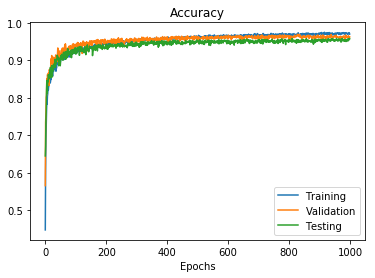

In [36]:
plt.plot(cell_model.history['accuracy'])
plt.plot(cell_model.history['val_accuracy'])
plt.plot(cell_model1.history['val_accuracy'])
plt.legend(['Training','Validation','Testing'])
plt.title('Accuracy')
plt.xlabel('Epochs')

In [37]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_generator)
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1


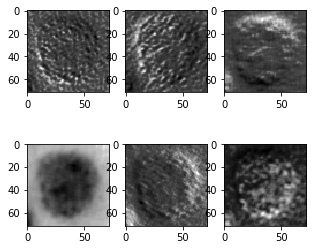

In [38]:
#output after input layer 1
display_activation(activations, 3, 2, 1)

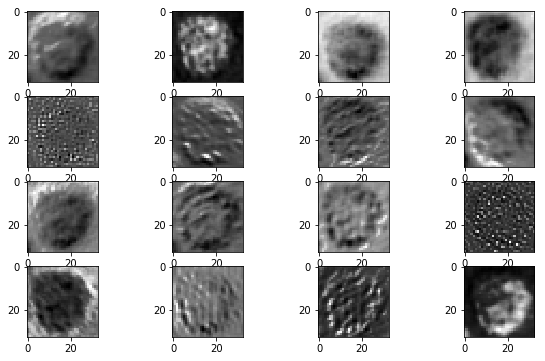

In [39]:
#output after input layer 4
display_activation(activations, 4, 4, 4)

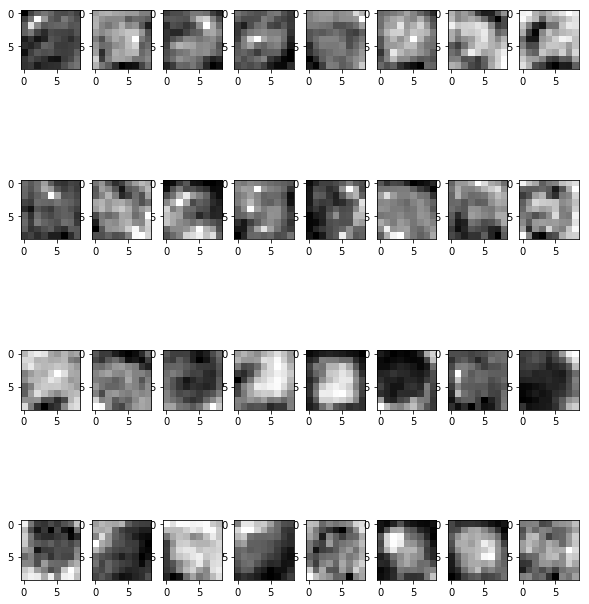

In [40]:
#output after input layer 7
display_activation(activations, 8, 4, 7)